# Group project - DATA201

> By Oscar Toohey, Jamie Barnes, Seth Gunn, Bach Vu, Angus Loader


# How COVID affect living price in New Zealand

## Data Source (dir `data/`):
| Location | Content | URL |
|----|----|----|
| `household.csv` | CPI |  |
| `Overseas.csv`| Import/Export by tonnes |  |
| `Number_of_covid.csv` | Covid statistic by Health Ministry |  |

### R libraries

In [2]:
library(tidyverse)
library(rvest)
library(magrittr) # better handling of pipes

library(purrr) # to work with lists and map functions
library(glue)
library(stringr) # to handle string conversion

# install.packages("zoo") # as.yearqtr
library(zoo)

library(ggplot2)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.3     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   2.0.0     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'rvest' was built under R version 4.1.1"

Attaching package: 'rvest'


The following object is masked from 'package:readr':

    guess_encoding



Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract



Attaching package: 'glue'


The following object is masked from 'package:dplyr':

    collapse


Warning message:
"package 'zoo' was built under R version 4.1.1"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.nume

### Covid stats


Import data

In [3]:
covid_case_df <- read_csv("data/Number_of_cases.csv")
hpi_df <- read_csv("data/household-living-costs-price-indexes-June-2021-quarter-time-series-indexes.csv")

covid_case_df %>% glimpse()
hpi_df %>% glimpse()

New names:
* `` -> ...1

Rows: 1554 Columns: 18

-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (13): ResourceID, Subject, Title, Description, Source, SourceURL, Frequ...
dbl   (3): ...1, Value, Multiplier
dttm  (1): Modified
date  (1): Period


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 45262 Columns: 11

-- Column specification --------------------------------------------------------
Delimiter: ","
chr (8): hlpi_name, series_ref, quarter, hlpi, nzhec, nzhec_name, nzhec_shor...
dbl (3): index, change.q, change.a


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



Rows: 1,554
Columns: 18
$ ...1        <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,~
$ ResourceID  <chr> "CPCOV2", "CPCOV2", "CPCOV2", "CPCOV2", "CPCOV2", "CPCOV2"~
$ Subject     <chr> "COVID-19", "COVID-19", "COVID-19", "COVID-19", "COVID-19"~
$ Title       <chr> "Number of Cases", "Number of Cases", "Number of Cases", "~
$ Description <chr> "COVID-19 cases in New Zealand (cumulative)", "COVID-19 ca~
$ Source      <chr> "Ministry of Health", "Ministry of Health", "Ministry of H~
$ SourceURL   <chr> "https://www.health.govt.nz/our-work/diseases-and-conditio~
$ Modified    <dttm> 2021-10-06 11:00:00, 2021-10-06 11:00:00, 2021-10-06 11:0~
$ Frequency   <chr> "Daily", "Daily", "Daily", "Daily", "Daily", "Daily", "Dai~
$ Var1        <chr> "Case status", "Case status", "Case status", "Case status"~
$ id          <chr> "3934f4da-e3ed-43c4-8656-441f49f9c7ca", "2a4fa96a-27a1-423~
$ Period      <date> 2020-02-28, 2020-02-29, 2020-03-01, 2020-03-02, 2020-03-0~
$ Duration    <c

Create helpers

In [4]:
convertToWeek <- function(date, format="%V-%Y") {
    return (strftime(date, format=format))
}

getFirstDayOfWeek <- function(date) {
    weekIndex = strtoi(convertToWeek(date, format="%V"), base=10L)
    year = convertToWeek(date, format="%Y")
    string <- paste(year, weekIndex, "1", sep="-") # 1 for Monday
    return (string)
}

getByStatus <- function(data, status, rename=FALSE) {
    result <- data %>% filter(Status==status)
    if (rename == TRUE) {
        result %<>% select(Value, Date) 
        names(result)[names(result) == 'Value'] <- status
    }
    return (result)
}

trim_Covid_Raw_df <-function(covid_df, option) {
    covid_df <- covid_df %>% rename(Status=Label1, Date=Period)
    covid_df %<>% mutate(
        Week = map_chr(Date, convertToWeek),
        Monday = map_chr(Date, getFirstDayOfWeek)
    )
    suppressWarnings( # There is not good record in raw data, see Failure in report
        covid_df <- transform(covid_df, Monday=as.Date(Monday, format="%Y-%U-%u"))
    )
    
    if (option == "Status") {
        covid_status_df <- covid_df %>% select(Value, Date, Status) %>%
                                        group_by(Status) %>% summarise()
        return (covid_status_df)        
    }
    
    deceased_covid_case_df <- getByStatus(covid_df, "Deceased", TRUE)
    recovered_covid_case_df <- getByStatus(covid_df, "Recovered", TRUE)
    active_covid_case_df <- getByStatus(covid_df, "Active", TRUE)
    if (option == "Deceased") {
        return (deceased_covid_case_df)
    } else if (option == "Recovered") {
        return (recovered_covid_case_df)
    } else if (option == "Active") {
        return (active_covid_case_df)
    }    
    
    temp <- merge(x = deceased_covid_case_df, y = recovered_covid_case_df, 
                  by = "Date", all = TRUE)
    covid_case_mutated_df <- merge(x = temp, y = active_covid_case_df, 
                                   by = "Date", all = TRUE) # Outer join
    if (option == "Sample") {        
        newdata <- covid_case_mutated_df %>% sample_n(10)
        return (newdata[order(newdata$Date),])
    } else if (option == "Summary") {
        return (covid_case_mutated_df) # Trim unecessary cols
    }
    
    return (covid_df)
}

savePlot <- function(filename, df_plot) {
    ggsave(paste("img", filename, sep="/"), plot = df_plot)
}

Explore data

In [5]:
# Test
trim_Covid_Raw_df(covid_case_df, "Status")
trim_Covid_Raw_df(covid_case_df, "Deceased") %>% glimpse()
trim_Covid_Raw_df(covid_case_df, "Recovered") %>% glimpse()
trim_Covid_Raw_df(covid_case_df, "Active") %>% glimpse()
trim_Covid_Raw_df(covid_case_df, "Sample")
trim_Covid_Raw_df(covid_case_df, "Summary") %>% glimpse()

Status
<chr>
Active
Deceased
Recovered


Rows: 518
Columns: 2
$ Deceased <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0~
$ Date     <date> 2020-02-28, 2020-02-29, 2020-03-01, 2020-03-02, 2020-03-05, ~
Rows: 518
Columns: 2
$ Recovered <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ~
$ Date      <date> 2020-02-28, 2020-03-01, 2020-02-29, 2020-03-03, 2020-03-02,~
Rows: 518
Columns: 2
$ Active <dbl> 1, 1, 1, 1, 1, 3, 3, 4, 5, 5, 5, 5, 5, 5, 6, 5, 8, 8, 12, 20, 2~
$ Date   <date> 2020-02-28, 2020-03-01, 2020-03-02, 2020-03-03, 2020-02-29, 20~


,Date,Deceased,Recovered,Active
,<date>,<dbl>,<dbl>,<dbl>
4,2020-06-25,22,1484,13
5,2020-07-01,22,1484,22
10,2020-08-09,22,1524,23
3,2020-10-31,25,1857,75
2,2020-11-06,25,1905,44
6,2021-02-03,25,2222,61
1,2021-03-21,26,2369,58
8,2021-06-04,26,2639,17
9,2021-08-25,26,2887,246


Rows: 518
Columns: 4
$ Date      <date> 2020-02-28, 2020-02-29, 2020-03-01, 2020-03-02, 2020-03-03,~
$ Deceased  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ~
$ Recovered <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ~
$ Active    <dbl> 1, 1, 1, 1, 1, 3, 3, 4, 5, 5, 5, 5, 5, 5, 5, 6, 8, 8, 12, 20~


Wraggle data and graphing

In [6]:
# Source: http://rstudio-pubs-static.s3.amazonaws.com/3256_bb10db1440724dac8fa40da5e658ada5.html
color <- c(rgb(1,0,0.4,1), rgb(0,1,0.4,1), rgb(0,0,1,1))
graph_df <- trim_Covid_Raw_df(covid_case_df, "")
graph_week_df <- graph_df %>%
    group_by(Monday, Status, Week) %>%
    summarise(Value = mean(Value))

options(repr.plot.width = 14, repr.plot.height = 10) # Size of graph display

`summarise()` has grouped output by 'Monday', 'Status'. You can override using the `.groups` argument.



In [7]:
new_case_plot <- ggplot(data = getByStatus(graph_df, "Active"), 
               aes(x=Date, y=Value)
        ) +
        geom_line(colour=color[1], size=2) +
#         geom_line(data = getByStatus(graph_df, "Recovered"), colour=color[2], size=2) +
#         geom_line(data = getByStatus(graph_df, "Deceased"), colour=color[3], size=2) +
        scale_color_manual(values=color) + theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
        scale_x_date(date_breaks = "months" , date_labels = "%b-%y")

new_case_plot <- new_case_plot +
ggtitle("New case by Week") +
ylab("Total cases") + xlab("Month")

In [8]:
graph_week_df$Status <- factor(graph_week_df$Status, 
                               levels = c("Active", "Recovered", "Deceased"))

covid_weekly_plot <- ggplot() +
        geom_bar(stat='identity', data = graph_week_df,
                aes(x=Monday, y=Value, fill=factor(Status))) +
        geom_line(data=getByStatus(graph_df, "Active"), colour=color[1], size=2,
                 aes(x=Date, y=Value)) +
        scale_color_manual(values=color) + theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
        scale_x_date(date_breaks = "months" , date_labels = "%b-%y")


covid_weekly_plot <- covid_weekly_plot +
ggtitle("Total case affected by Covid Weekly") +
ylab("Total cases") + xlab("Months") +
labs(fill="Status")

Show plots result

In [9]:
# Show Plots
# new_case_plot
# covid_weekly_plot

# Save Plots
savePlot("covid_new_case_weekly.png", new_case_plot)
savePlot("covid_case_weekly.png", covid_weekly_plot)

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message:
"Removed 6 rows containing missing values (position_stack)."


### Living household Index (CPI)

In [10]:
HH_LC_PI_df <- read_csv(file = "data/household-living-costs-price-indexes-June-2021-quarter-time-series-indexes.csv")
HH_LC_PI_df %>% head()

Rows: 45262 Columns: 11

-- Column specification --------------------------------------------------------
Delimiter: ","
chr (8): hlpi_name, series_ref, quarter, hlpi, nzhec, nzhec_name, nzhec_shor...
dbl (3): index, change.q, change.a


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



hlpi_name,series_ref,quarter,hlpi,nzhec,nzhec_name,nzhec_short,level,index,change.q,change.a
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
All households,HPIQ.SALL01,2008Q2,allhh,1,Food,Food,group,870,NA,NA
All households,HPIQ.SALL01,2008Q3,allhh,1,Food,Food,group,903,3.8,NA
All households,HPIQ.SALL01,2008Q4,allhh,1,Food,Food,group,918,1.7,NA
All households,HPIQ.SALL01,2009Q1,allhh,1,Food,Food,group,927,1.0,NA
All households,HPIQ.SALL01,2009Q2,allhh,1,Food,Food,group,935,0.9,7.5
All households,HPIQ.SALL01,2009Q3,allhh,1,Food,Food,group,949,1.5,5.1


Wrangle data

In [11]:
interested_groups <- c("Petrol", "Food", "All groups")
CPI_PRF <- HH_LC_PI_df %>% 
    filter(hlpi_name == "All households", 
        (nzhec_name %in% interested_groups) | (nzhec_short == "Rent" & level == "subgroup")
    ) %>%
    select(quarter, nzhec_short, index) %>%
    spread(key = nzhec_short, value = index)
CPI_PRF %>% head()
write.csv(CPI_PRF, "data/Wrangled_CPI.csv")

quarter,All groups,Food,Petrol,Rent
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2008Q2,898,870,915,895
2008Q3,911,903,957,902
2008Q4,906,918,743,906
2009Q1,903,927,736,908
2009Q2,905,935,760,910
2009Q3,914,949,775,912


PLot

geom_line: na.rm = FALSE, orientation = NA
stat_identity: na.rm = FALSE
position_identity 

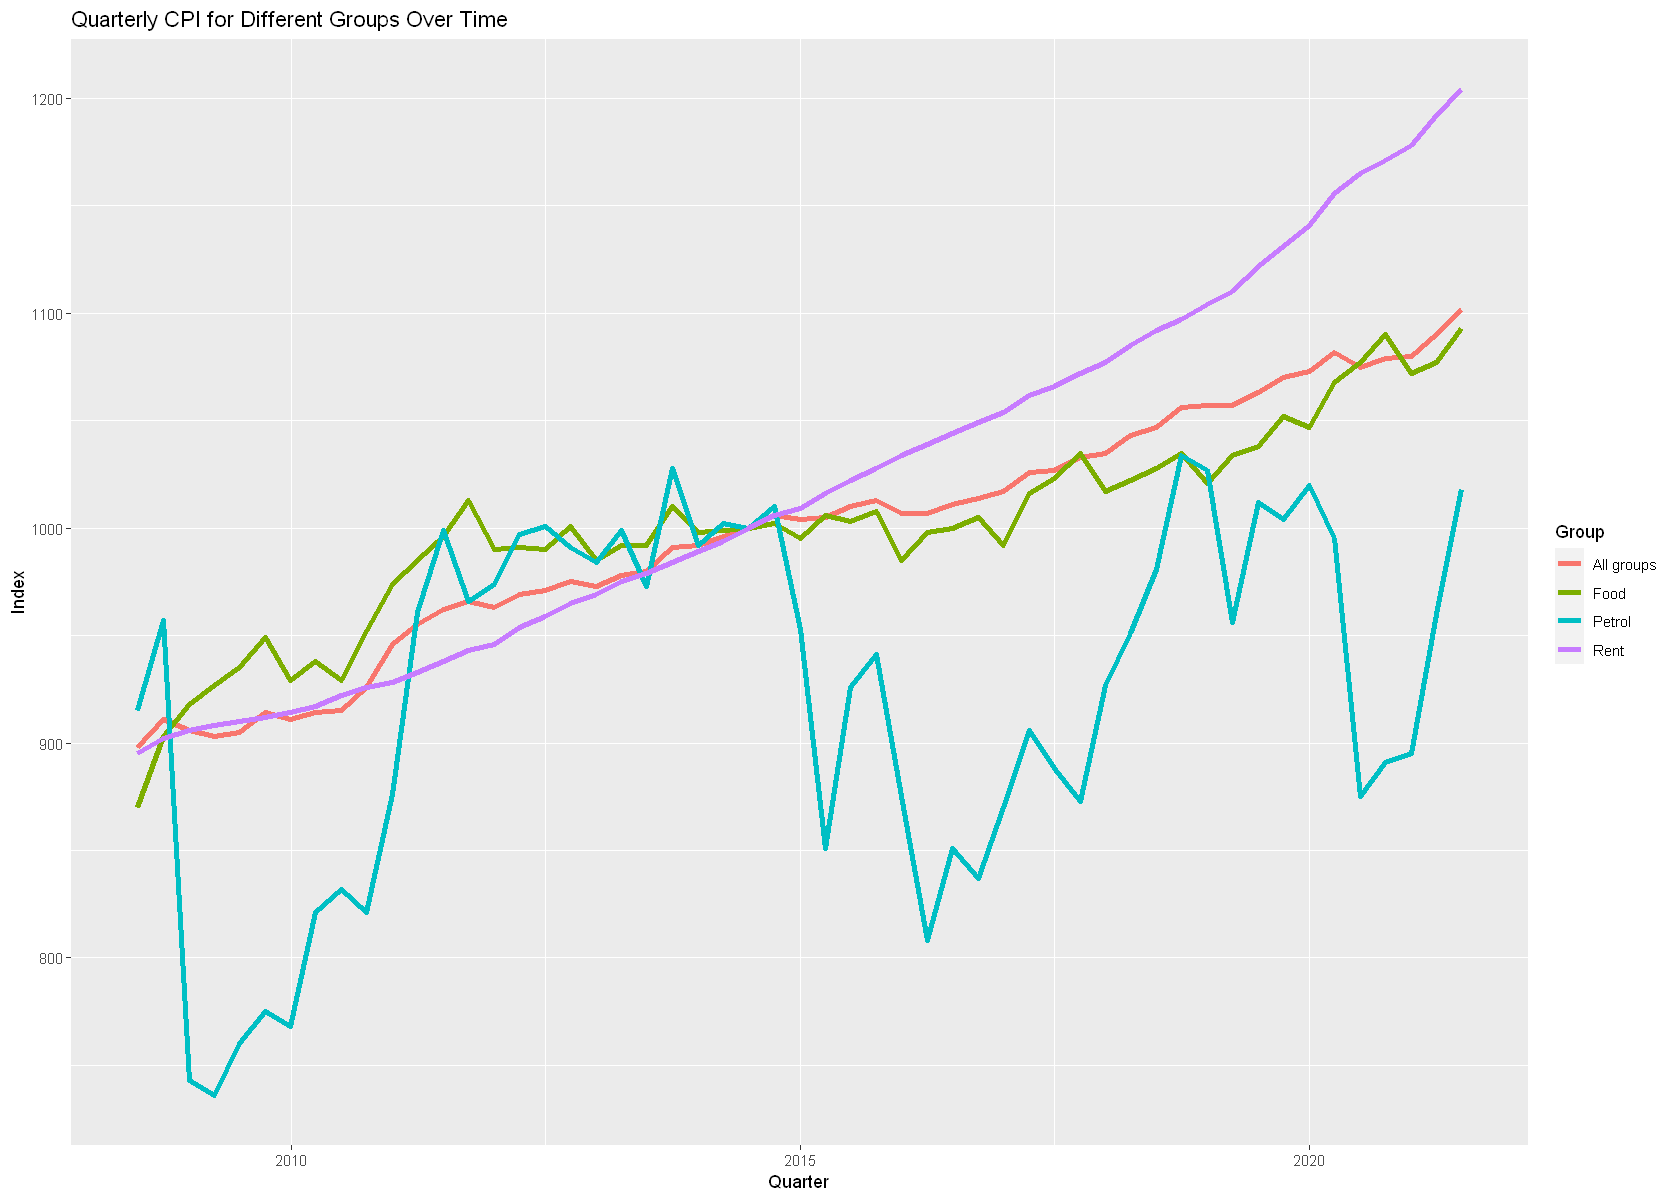

In [12]:
cpi_plot <- CPI_PRF %>%
    gather(key = group, value = index, -quarter) %>%
    arrange(quarter) %>%
    mutate(quarter = as.Date(as.yearqtr(quarter, format = "%YQ%q"), frac = 1)) %>%
    ggplot(mapping = aes(x = quarter, y = index, group = group, colour = group)) +
    scale_colour_discrete("Group") + ggtitle("Quarterly CPI for Different Groups Over Time") +
    ylab("Index") + xlab("Quarter") + geom_line(lwd=1.5)
    geom_line()
cpi_plot

### Import/Export factors

## Combine all factors

In [13]:
cpi_2020_df <- CPI_PRF %>%
    gather(key = group, value = index, -quarter) %>%
    rename(Group=group, HPI=index, Quarter=quarter) %>% arrange(Quarter) %>% 
    mutate(Quarter = as.Date(as.yearqtr(Quarter, format = "%YQ%q"), frac = 1),
          HPI = HPI*4) %>%
    filter(Quarter >= as.Date("2019-10-01"))

# Brrrrrr
graph_df %>% head()
graph_week_df %>% head()
cpi_2020_df %>% head()

,...1,ResourceID,Subject,Title,Description,Source,SourceURL,Modified,Frequency,Var1,id,Date,Duration,Status,Value,Unit,Measure,Multiplier,Week,Monday
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<chr>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<date>
1,1,CPCOV2,COVID-19,Number of Cases,COVID-19 cases in New Zealand (cumulative),Ministry of Health,https://www.health.govt.nz/our-work/diseases-and-conditions/covid-19-novel-coronavirus/covid-19-data-and-statistics/testing-covid-19,2021-10-06 11:00:00,Daily,Case status,3934f4da-e3ed-43c4-8656-441f49f9c7ca,2020-02-28,P1D,Deceased,0,Number,COVID-19 cases,0,09-2020,2020-03-02
2,2,CPCOV2,COVID-19,Number of Cases,COVID-19 cases in New Zealand (cumulative),Ministry of Health,https://www.health.govt.nz/our-work/diseases-and-conditions/covid-19-novel-coronavirus/covid-19-data-and-statistics/testing-covid-19,2021-10-06 11:00:00,Daily,Case status,2a4fa96a-27a1-423b-9204-09422b97f798,2020-02-29,P1D,Deceased,0,Number,COVID-19 cases,0,09-2020,2020-03-02
3,3,CPCOV2,COVID-19,Number of Cases,COVID-19 cases in New Zealand (cumulative),Ministry of Health,https://www.health.govt.nz/our-work/diseases-and-conditions/covid-19-novel-coronavirus/covid-19-data-and-statistics/testing-covid-19,2021-10-06 11:00:00,Daily,Case status,93e22517-42a3-4a48-a6cf-80e1cf355528,2020-03-01,P1D,Deceased,0,Number,COVID-19 cases,0,09-2020,2020-03-02
4,4,CPCOV2,COVID-19,Number of Cases,COVID-19 cases in New Zealand (cumulative),Ministry of Health,https://www.health.govt.nz/our-work/diseases-and-conditions/covid-19-novel-coronavirus/covid-19-data-and-statistics/testing-covid-19,2021-10-06 11:00:00,Daily,Case status,7e015a63-e186-482c-b8ba-a22257f54789,2020-03-02,P1D,Deceased,0,Number,COVID-19 cases,0,10-2020,2020-03-09
5,5,CPCOV2,COVID-19,Number of Cases,COVID-19 cases in New Zealand (cumulative),Ministry of Health,https://www.health.govt.nz/our-work/diseases-and-conditions/covid-19-novel-coronavirus/covid-19-data-and-statistics/testing-covid-19,2021-10-06 11:00:00,Daily,Case status,ba41cf0e-5d23-4236-b6cf-a42b42db10c6,2020-03-05,P1D,Deceased,0,Number,COVID-19 cases,0,10-2020,2020-03-09
6,6,CPCOV2,COVID-19,Number of Cases,COVID-19 cases in New Zealand (cumulative),Ministry of Health,https://www.health.govt.nz/our-work/diseases-and-conditions/covid-19-novel-coronavirus/covid-19-data-and-statistics/testing-covid-19,2021-10-06 11:00:00,Daily,Case status,8366f989-09b3-46a5-97fa-bde0f0a46f4f,2020-03-06,P1D,Deceased,0,Number,COVID-19 cases,0,10-2020,2020-03-09


Monday,Status,Week,Value
<date>,<fct>,<chr>,<dbl>
2020-03-02,Active,09-2020,1.000000
2020-03-02,Deceased,09-2020,0.000000
2020-03-02,Recovered,09-2020,0.000000
2020-03-09,Active,10-2020,3.142857
2020-03-09,Deceased,10-2020,0.000000
2020-03-09,Recovered,10-2020,0.000000


Quarter,Group,HPI
<date>,<chr>,<dbl>
2019-12-31,All groups,4292
2019-12-31,Food,4188
2019-12-31,Petrol,4080
2019-12-31,Rent,4564
2020-03-31,All groups,4328
2020-03-31,Food,4272


In [16]:
color <- c(rgb(1,0,0.4,1), rgb(0,1,0.4,1), rgb(0,0,1,1), rgb(0,0,0,1))
covid_weekly_plot <- ggplot() +
        geom_bar(stat='identity', data = graph_week_df, alpha=0.3,
                 aes(x=Monday, y=Value, fill=factor(Status)) ) +
        geom_line(data=getByStatus(graph_df, "Active"), colour=color[1], size=2,
                 aes(x=Date, y=Value)) +
        geom_line(data=getByStatus(graph_df, "Deceased"), colour=color[3], size=1,
                 aes(x=Date, y=Value)) +

        geom_line(lwd=1.5, data=cpi_2020_df,
                 aes(x=Quarter, y=HPI, group=Group, colour=Group)) +

        scale_y_continuous("Total case", 
            sec.axis = sec_axis(~ . *0.25, name = "Index")
        ) +
        scale_color_manual(values=color) + theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
        scale_x_date(date_breaks = "months" , date_labels = "%b-%y")


covid_weekly_plot <- covid_weekly_plot +
ggtitle("Title Graph") +
ylab("Total cases") + xlab("Months") +
labs(fill="Status")

cpi_2020_plot <- cpi_2020_df %>%
    ggplot(mapping = aes(x = Quarter, y = HPI, group = Group, colour = Group)) +
    scale_colour_discrete("Group") + ggtitle("Quarterly CPI for Different Groups Over Time") +
    ylab("Index") + xlab("Quarter") + geom_line(lwd=1.5)


Warning message:
"Removed 6 rows containing missing values (position_stack)."


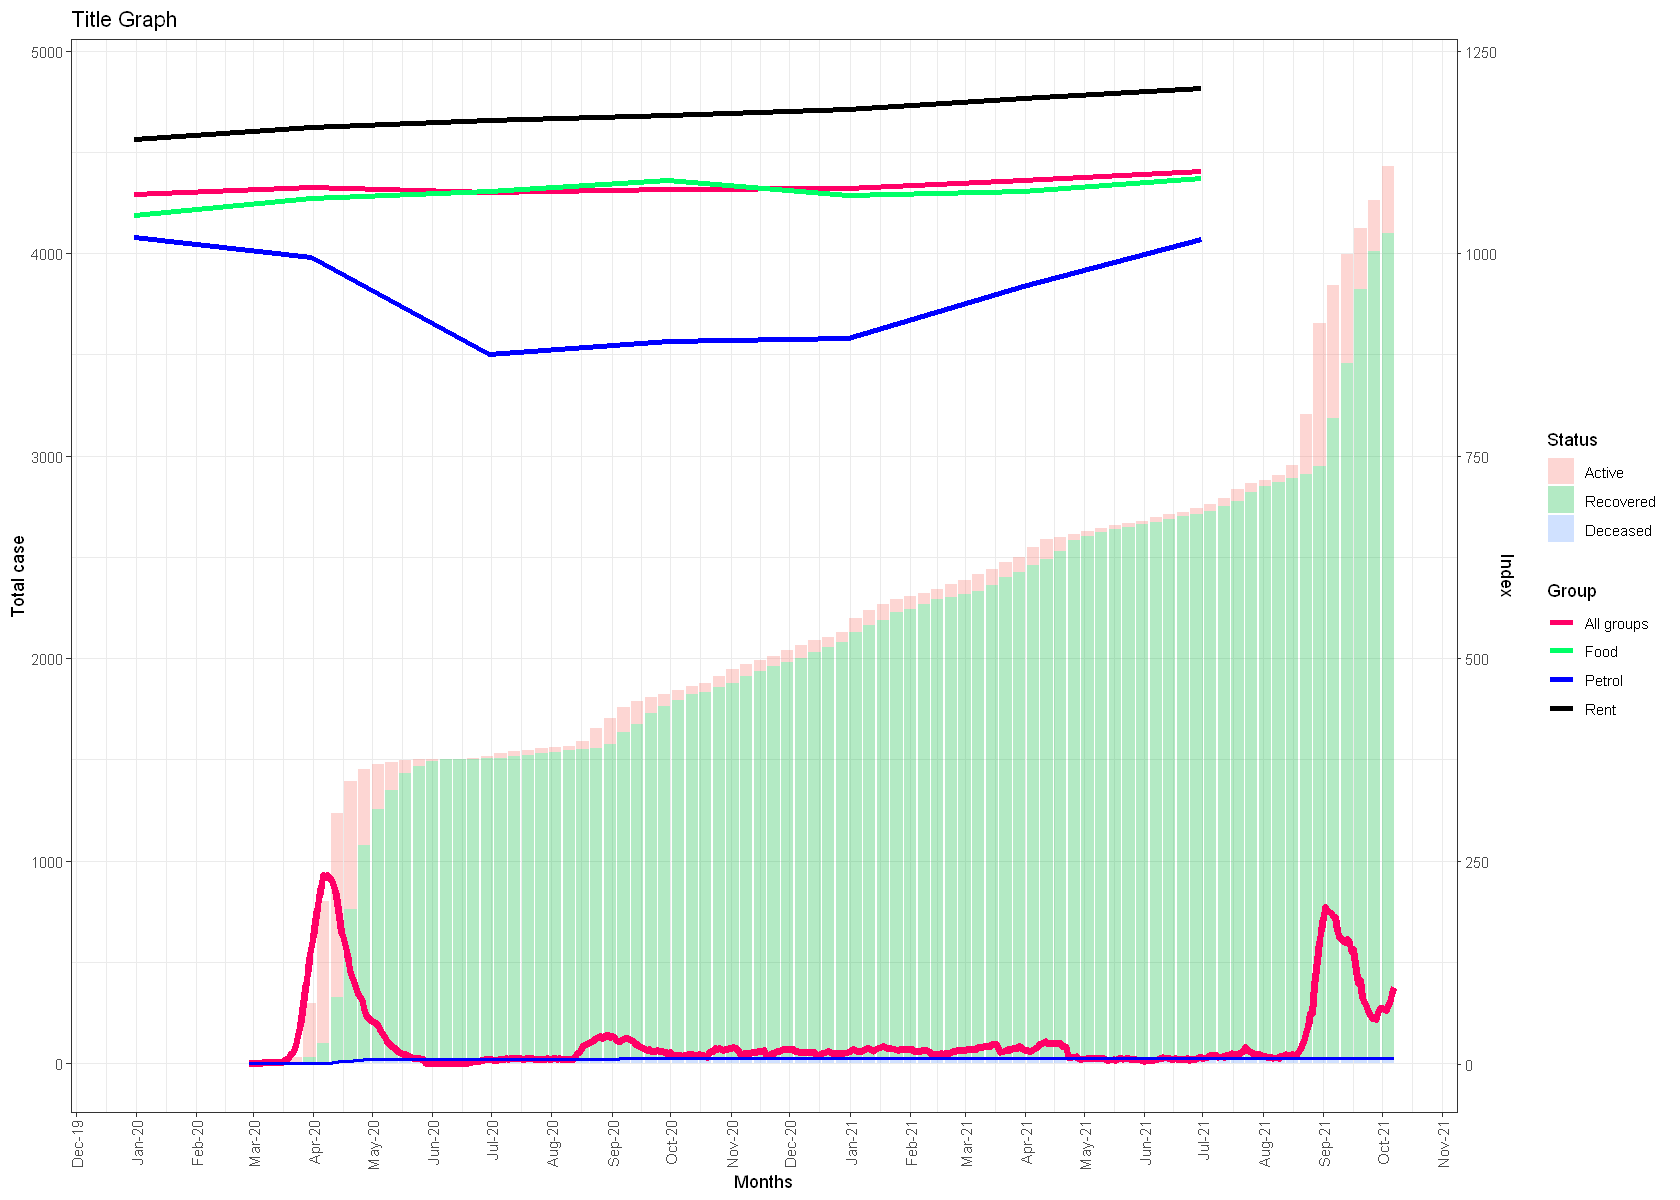

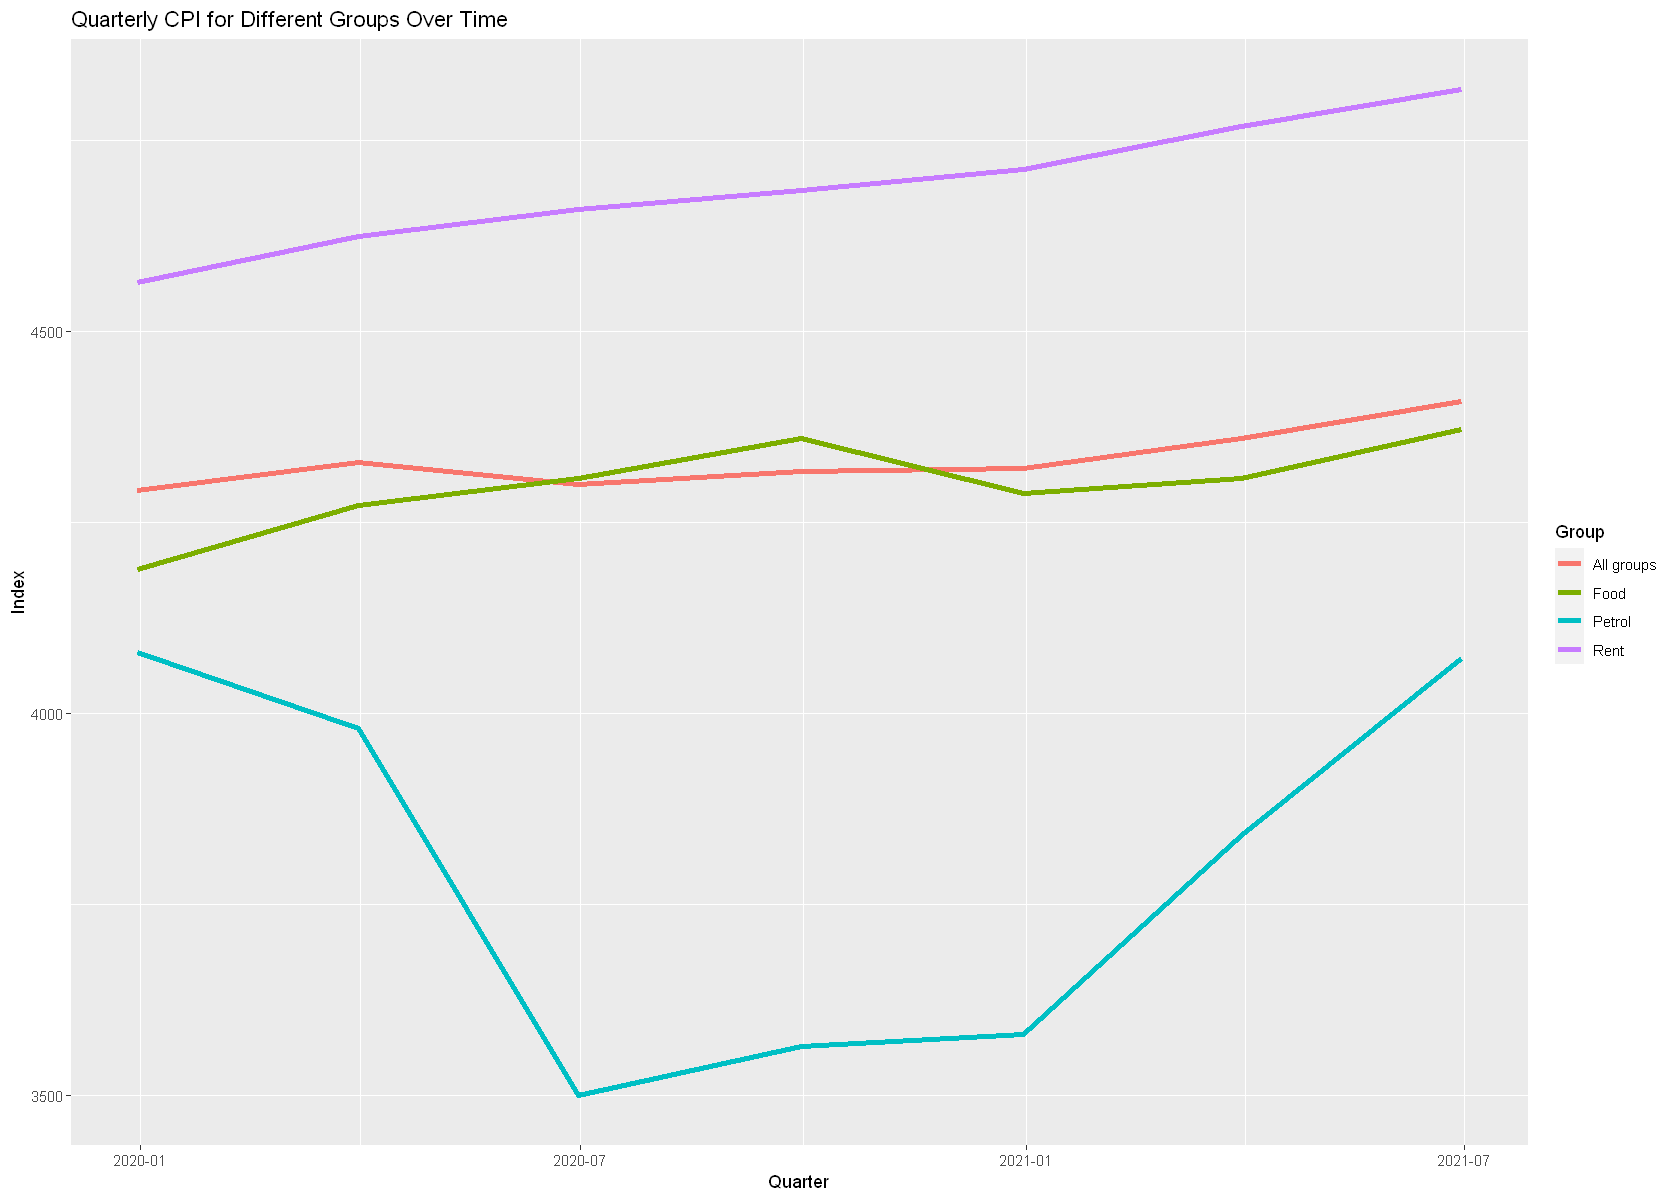

In [17]:
covid_weekly_plot
# savePlot("CombinedPlot.png", covid_weekly_plot)
cpi_2020_plot